In [1]:
!pip install scikit-learn==1.1.3 --force-reinstall
!pip install numpy==1.24.3

  Using cached scikit_learn-1.1.3-cp39-cp39-macosx_10_9_x86_64.whl (8.7 MB)
  Using cached scipy-1.13.1-cp39-cp39-macosx_10_9_x86_64.whl (39.4 MB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
  Using cached numpy-2.0.2-cp39-cp39-macosx_10_9_x86_64.whl (21.2 MB)
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.5.0
    Uninstalling threadpoolctl-3.5.0:
      Successfully uninstalled threadpoolctl-3.5.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: scikit-lear

# Import Libraries

In [36]:
import pandas as pd
import numpy as np
import warnings
import re
from scipy import stats
import sklearn
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as mp
import seaborn as sb
from catboost import CatBoostRegressor

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt 

In [4]:
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Import data

In [5]:
train_data = pd.read_csv('train_v9rqX0R.csv')
test_data = pd.read_csv('test_AbJTz2l.csv')

In [6]:
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Data Understanding

In [7]:
temp_df = train_data.copy()
temp_df['Unique_Key'] = train_data['Item_Identifier'] + train_data['Outlet_Identifier']

In [8]:
print('Shape :',train_data.shape)
print('Unique item count :',temp_df['Unique_Key'].nunique(),'Level of Data :','Item_Identifier')

Shape : (8523, 12)
Unique item count : 8523 Level of Data : Item_Identifier


##### Hence data is at [Item,Outlet] level

In [9]:
train_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [10]:
all_cols=train_data.columns.tolist()
num_cols=train_data._get_numeric_data().columns.tolist()
cat_cols=list(set(all_cols)-set(num_cols))

## Numerical Columns

In [11]:
num_desc=train_data[num_cols].describe().T
num_desc['skewness']=train_data[num_cols].skew()
num_desc['kurtosis']=train_data[num_cols].kurt()
num_desc

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000,0.082426,-1.227766
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391,1.167091,1.679445
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400,0.127202,-0.889769
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000,-0.396641,-1.205694
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800,1.177531,1.615877


## Categorical Columns

In [12]:
cat_summary = pd.DataFrame()

# Assuming cat_cols is already defined
lis_cols = cat_cols.copy()
lis_cols.remove('Outlet_Identifier')
lis_cols.remove('Item_Identifier')

for i in lis_cols:
    lat_summ = train_data[i].value_counts(dropna=False).reset_index()
    lat_summ.columns = ['Category', 'Frequency']
    lat_summ['Feature'] = i
    lat_summ = lat_summ[['Feature', 'Category', 'Frequency']]

    # Correctly concatenate without unnecessary pd.DataFrame()
    cat_summary = pd.concat([cat_summary, lat_summ], ignore_index=True)

cat_summary = cat_summary.reset_index(drop=True)
print(cat_summary.head(200))

                 Feature               Category  Frequency
0       Item_Fat_Content                Low Fat       5089
1       Item_Fat_Content                Regular       2889
2       Item_Fat_Content                     LF        316
3       Item_Fat_Content                    reg        117
4       Item_Fat_Content                low fat        112
5              Item_Type  Fruits and Vegetables       1232
6              Item_Type            Snack Foods       1200
7              Item_Type              Household        910
8              Item_Type           Frozen Foods        856
9              Item_Type                  Dairy        682
10             Item_Type                 Canned        649
11             Item_Type           Baking Goods        648
12             Item_Type     Health and Hygiene        520
13             Item_Type            Soft Drinks        445
14             Item_Type                   Meat        425
15             Item_Type                 Breads        2

## Missing value analysis

In [13]:
percent_missing= (train_data.isnull().sum().sum()/(train_data.shape[0]*train_data.shape[1]))*100
print('Total % missing :', percent_missing)

Total % missing : 3.786812155344362


In [14]:
train_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

(array([ 67., 148., 268., 275., 254., 341., 278., 317., 270., 246., 239.,
        179., 293., 265., 221., 242., 206., 181., 239., 287., 229., 274.,
        170., 291., 215., 243., 219., 229., 280.,  94.]),
 array([ 4.555     ,  5.11483333,  5.67466667,  6.2345    ,  6.79433333,
         7.35416667,  7.914     ,  8.47383333,  9.03366667,  9.5935    ,
        10.15333333, 10.71316667, 11.273     , 11.83283333, 12.39266667,
        12.9525    , 13.51233333, 14.07216667, 14.632     , 15.19183333,
        15.75166667, 16.3115    , 16.87133333, 17.43116667, 17.991     ,
        18.55083333, 19.11066667, 19.6705    , 20.23033333, 20.79016667,
        21.35      ]),
 <BarContainer object of 30 artists>)

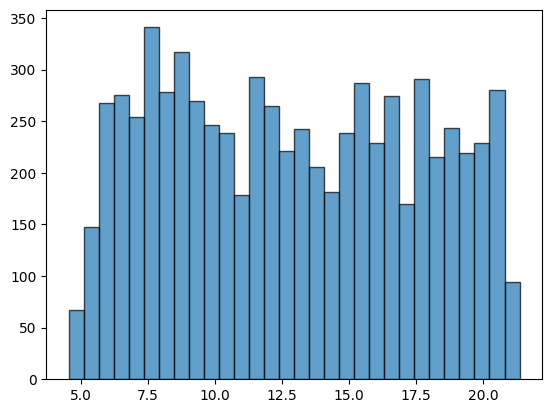

In [15]:
## Check distribution of Item Weight
plt.hist(train_data['Item_Weight'], bins=30, edgecolor='black', alpha=0.7)


In [16]:
## Data is evenly distributed - imputing with mean

avg_item_weight = train_data['Item_Weight'].mean()

train_data['Item_Weight'] = train_data['Item_Weight'].fillna(avg_item_weight)

In [17]:
label_encoder = LabelEncoder()
train_data['Outlet_Size'] = label_encoder.fit_transform(train_data['Outlet_Size'].astype(str))

In [18]:
# Columns to impute
cols_to_impute = ['Outlet_Size']

# Define the imputer
knn_imputer = KNNImputer(n_neighbors=3)

train_imputed_values = knn_imputer.fit_transform(train_data[cols_to_impute])
train_imputed = pd.DataFrame(train_imputed_values, columns=cols_to_impute)

train_data[cols_to_impute] = train_imputed
train_data['Outlet_Size'] =train_data['Outlet_Size'].astype('category')

In [19]:
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,1.0,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,1.0,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,1.0,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,3.0,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,0.0,Tier 3,Supermarket Type1,994.7052


In [20]:
train_data.dtypes

Item_Identifier                object
Item_Weight                   float64
Item_Fat_Content               object
Item_Visibility               float64
Item_Type                      object
Item_MRP                      float64
Outlet_Identifier              object
Outlet_Establishment_Year       int64
Outlet_Size                  category
Outlet_Location_Type           object
Outlet_Type                    object
Item_Outlet_Sales             float64
dtype: object

In [21]:
columns_to_drop = ['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year', 'Item_Outlet_Sales']

def drop_cols(df,cols):
  drop_cols = []
  for i in columns_to_drop:
    if i in cols:
      drop_cols.append(i)

  df2 = df.drop(columns=drop_cols)
  return df2


X_train = drop_cols(train_data,train_data.columns.tolist())
y_train = train_data[['Item_Outlet_Sales']]

In [22]:
print(X_train.shape)
print(y_train.shape)

(8523, 8)
(8523, 1)


In [23]:
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,9.30,Low Fat,0.016047,Dairy,249.8092,1.0,Tier 1,Supermarket Type1
1,5.92,Regular,0.019278,Soft Drinks,48.2692,1.0,Tier 3,Supermarket Type2
2,17.50,Low Fat,0.016760,Meat,141.6180,1.0,Tier 1,Supermarket Type1
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,3.0,Tier 3,Grocery Store
4,8.93,Low Fat,0.000000,Household,53.8614,0.0,Tier 3,Supermarket Type1


In [24]:
y_train.head()

,Item_Outlet_Sales
0,3735.1380
1,443.4228
2,2097.2700
3,732.3800
4,994.7052


In [25]:
cat_cols = ['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type']
X_train = pd.get_dummies(X_train, columns = cat_cols, drop_first=True)

X_train = X_train.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)

## Outlier treatment

#### Limit outlier values to 99th percentile

In [26]:
numerical_cols = X_train.select_dtypes(include=["float64"]).columns.tolist()

num_cols = numerical_cols.copy()
outlier_dict={}
for cols in num_cols:
    perc_val=X_train[cols].quantile(0.99)
    outlier_dict[cols]=perc_val
    for i,j in X_train.iterrows():
        if X_train.loc[i,cols]>perc_val:
            X_train.loc[i,cols]=perc_val

## Scaling numeric values

In [27]:
scaler = MinMaxScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

## Check for Quasi-Constant features

In [28]:
df_cont = X_train.describe().loc['std'] == 0
df_lis = df_cont[df_cont].index.tolist()
print(len(df_lis), 'constant features detected')

0 constant features detected


## Correlation plot to understand if any features are highly correlated with each other

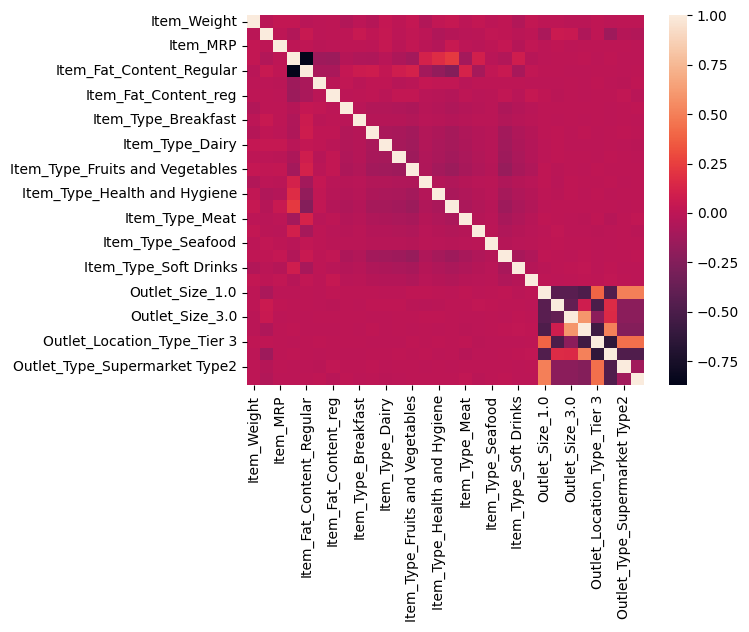

In [29]:
plot = sb.heatmap(X_train.corr())
  
# displaying heatmap
mp.show()

## Variance Inflation Factor

In [30]:
vifs = pd.DataFrame()
col_to_drop=[]
vifs["feature"] = X_train.columns
  
# calculating VIF for each feature
vifs["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]

col_to_drop = vifs[vifs['VIF']>10]['feature'].tolist()

for col in col_to_drop:
    X_train.drop(col,axis=1,inplace=True)
    
print(len(col_to_drop), 'columns dropped from training set to tackle multi-collinearity')
print('Training set shape :', X_train.shape)

2 columns dropped from training set to tackle multi-collinearity
Training set shape : (8523, 28)


## Feature Selection

In [31]:
final_features=[]
n_features = 50 ## Choose number of features to consider from each embedded model
feature_set_op = 'intersection' ## Choose either 'intersection' or 'union'

In [37]:
rf_list=[]
X = X_train.copy()
y = y_train

rf = RandomForestRegressor(random_state=45)
rf_model = rf.fit(X,y)

rf_coeff=pd.DataFrame()
rf_coeff['Importance']= pd.DataFrame(np.round(rf_model.feature_importances_,4)).abs()
rf_coeff_df = pd.DataFrame(columns=('Feature','Importance'))
rf_coeff_df = pd.concat([pd.DataFrame(X.columns), rf_coeff['Importance']],axis=1)
rf_coeff_df.rename(columns={0:'Features'},inplace=True)
rf_coeff_df.sort_values(by='Importance',ascending=False,inplace=True)
rf_list = rf_coeff_df[:n_features]['Features'].tolist()

/var/folders/5t/frmh3n710djg76jw6x2q223w0000gn/T/ipykernel_37330/3986109769.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = rf.fit(X,y)


In [38]:
xgb_list=[]
X = X_train.copy()
y = y_train.astype('int')

xgb = GradientBoostingRegressor(random_state=45)
xgb_model = xgb.fit(X,y)

xgb_coeff=pd.DataFrame()
xgb_coeff['Importance']= pd.DataFrame(np.round(xgb_model.feature_importances_,4)).abs()
xgb_coeff_df = pd.DataFrame(columns=('Feature','Importance'))
xgb_coeff_df = pd.concat([pd.DataFrame(X.columns), xgb_coeff['Importance']],axis=1)
xgb_coeff_df.rename(columns={0:'Features'},inplace=True)
xgb_coeff_df.sort_values(by='Importance',ascending=False,inplace=True)
xgb_list = xgb_coeff_df[:n_features]['Features'].tolist()

/Users/debarpanbagchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
if feature_set_op=='intersection':
    final_features= list(set(rf_list).intersection(set(xgb_list)))
else:
    final_features= list(set(rf_list).union(set(xgb_list)))
    
print(len(final_features),'final features selected post',feature_set_op)
feat = pd.DataFrame(final_features)
feat

28 final features selected post intersection


,0
0,Outlet_Location_Type_Tier 2
1,Outlet_Size_3.0
2,Item_Visibility
3,Outlet_Type_Supermarket Type3
4,Item_Fat_Content_low fat
5,Outlet_Type_Supermarket Type2
6,Item_Type_Meat
7,Item_Type_Snack Foods
8,Item_Type_Fruits and Vegetables
9,Outlet_Location_Type_Tier 3


## Fit Model

In [58]:
X = X_train[final_features]
model = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [10, 15, 20, 30, 50, 100],  # Max depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4], # Minimum samples required to be at a leaf node
}

grid_search = RandomizedSearchCV(model, param_distributions = param_grid, n_iter=1000, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=100)
model_opt = grid_search.fit(X,y_train)
opt_params = model_opt.best_params_
regressor = model.set_params(**opt_params)
decisiontree_model = regressor.fit(X,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Users/debarpanbagchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 54 is smaller than n_iter=1000. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [42]:
X = X_train[final_features]
model = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
    'max_depth': [10, 15, 20, 30],  # Max depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4], # Minimum samples required to be at a leaf node
    "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2],
    "subsample": [0.8, 1.0] 
}
grid_search = RandomizedSearchCV(model, param_distributions = param_grid, n_iter=50, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=100)
model_opt = grid_search.fit(X,y_train)
opt_params = model_opt.best_params_
regressor = model.set_params(**opt_params)
xgb_model = regressor.fit(X,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/debarpanbagchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/debarpanbagchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/debarpanbagchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/debarpanbagchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d

In [116]:
X = X_train[final_features]
model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
    'max_depth': [10, 15, 20, 30, 50],  # Max depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4] # Minimum samples required to be at a leaf node
}
grid_search = RandomizedSearchCV(model, param_distributions = param_grid, n_iter=100, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=100)
model_opt = grid_search.fit(X,y_train)
opt_params = model_opt.best_params_
regressor = model.set_params(**opt_params)
rf_model = regressor.fit(X,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/debarpanbagchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/debarpanbagchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/debarpanbagchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/debarpanbagchi/opt/anaconda3/lib/python3.9/site-packages/skl

In [ ]:
X = X_train[final_features]
model = CatBoostRegressor(random_state = 45)

param_grid = {
    "depth": [6,10,12],         # Tree depth. Shallower trees help reduce overfitting
    "learning_rate": [0.001, 0.01, 0.05, 0.1],  # Lower learning rates help generalization
    "l2_leaf_reg": [3, 5, 7],    # Regularization to reduce overfitting
    "bagging_temperature": [1, 1.5],  # Introduces randomness for better generalization
    "random_strength": [3],  # Randomization to reduce overfitting
    "early_stopping_rounds": [20],  # Stop training early if no improvement in validation score
}


grid_search = RandomizedSearchCV(model, param_distributions = param_grid, n_iter=50, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=100)
model_opt = grid_search.fit(X,y_train)
opt_params = model_opt.best_params_
regressor = model.set_params(**opt_params)
catboost_model = regressor.fit(X,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 2/54] START max_depth=10, min_samples_leaf=1, min_samples_split=5......
[CV 1/5; 2/54] END max_depth=10, min_samples_leaf=1, min_samples_split=5;, score=-1213.951 total time=   0.0s
[CV 4/5; 3/54] START max_depth=10, min_samples_leaf=1, min_samples_split=10.....
[CV 4/5; 3/54] END max_depth=10, min_samples_leaf=1, min_samples_split=10;, score=-1196.281 total time=   0.0s
[CV 3/5; 5/54] START max_depth=10, min_samples_leaf=2, min_samples_split=5......
[CV 3/5; 5/54] END max_depth=10, min_samples_leaf=2, min_samples_split=5;, score=-1202.050 total time=   0.0s
[CV 2/5; 7/54] START max_depth=10, min_samples_leaf=4, min_samples_split=2......
[CV 2/5; 7/54] END max_depth=10, min_samples_leaf=4, min_samples_split=2;, score=-1169.402 total time=   0.0s
[CV 1/5; 9/54] START max_depth=10, min_samples_leaf=4, min_samples_split=10.....
[CV 1/5; 9/54] END max_depth=10, min_samples_leaf=4, min_samples_split=10;, score=-1188.401 

/Users/debarpanbagchi/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


695:	learn: 836.1961675	total: 3.98s	remaining: 1.74s
696:	learn: 836.0234742	total: 3.98s	remaining: 1.73s
697:	learn: 835.8906670	total: 3.98s	remaining: 1.72s
698:	learn: 835.6343602	total: 3.98s	remaining: 1.72s
699:	learn: 835.5500655	total: 3.99s	remaining: 1.71s
700:	learn: 835.4288571	total: 3.99s	remaining: 1.7s
701:	learn: 835.0782829	total: 4.02s	remaining: 1.71s
702:	learn: 834.8732719	total: 4.03s	remaining: 1.7s
703:	learn: 834.7004312	total: 4.03s	remaining: 1.69s
704:	learn: 834.4375743	total: 4.04s	remaining: 1.69s
705:	learn: 834.1499018	total: 4.05s	remaining: 1.69s
706:	learn: 833.9357424	total: 4.05s	remaining: 1.68s
707:	learn: 833.8165607	total: 4.05s	remaining: 1.67s
708:	learn: 833.6563006	total: 4.05s	remaining: 1.66s
709:	learn: 833.4829849	total: 4.06s	remaining: 1.66s
710:	learn: 833.3891642	total: 4.06s	remaining: 1.65s
711:	learn: 833.1009991	total: 4.06s	remaining: 1.64s
712:	learn: 832.9318865	total: 4.07s	remaining: 1.64s
713:	learn: 832.7292863	total:

In [11]:
# Save the trained model to a file
best_model.save_model('xgb_model.cbm')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:22:22] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


**Predicting output for test set**

In [44]:
test_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


Fill missing values with knn imputer fit on training data

In [45]:
## Imputing with mean from the training set
test_data['Item_Weight'] = test_data['Item_Weight'].fillna(avg_item_weight)

## Fitting label encoder and knn imputer from training set to test set
test_data['Outlet_Size'] = label_encoder.transform(test_data['Outlet_Size'].astype(str))

test_imputed_values = knn_imputer.transform(test_data[cols_to_impute])
test_imputed = pd.DataFrame(test_imputed_values, columns=cols_to_impute)

test_data[cols_to_impute] = test_imputed
test_data['Outlet_Size'] =test_data['Outlet_Size'].astype('category')

In [46]:
X_test = drop_cols(test_data,test_data.columns.tolist())

cat_cols = ['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type']
X_test = pd.get_dummies(X_test, columns = cat_cols, drop_first=True)

X_test = X_test.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)

In [47]:
for cols in num_cols:
    perct_val = outlier_dict[cols]
    for i,j in X_test.iterrows():
        if X_test.loc[i,cols]>perct_val:
            X_test.loc[i,cols]=perct_val

X_test[num_cols] = scaler.transform(X_test[num_cols])

In [48]:
training_cols = X_train.columns.tolist()
testing_cols = X_test.columns.tolist()
cols_test_drop = []

for i in testing_cols:
    if i not in training_cols:
        cols_test_drop.append(i)

X_test.drop(columns = cols_test_drop, inplace =True)
X_test.shape


(5681, 28)

In [59]:
X_test.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_2.0,Outlet_Size_3.0,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0.993863,0.033436,0.330433,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,0.229825,0.169847,0.241786,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0
2,0.616447,0.440112,0.908218,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
3,0.169377,0.068015,0.533995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0
4,0.509521,0.524198,0.875751,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


## Predict Item Outlet Sales

In [60]:
# X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
y_pred = catboost_model.predict(X_test)

/Users/debarpanbagchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [61]:
submission_df = test_data[['Item_Identifier','Outlet_Identifier']]
submission_df['Item_Outlet_Sales'] = y_pred
submission_df.head()

/var/folders/5t/frmh3n710djg76jw6x2q223w0000gn/T/ipykernel_37330/1059374844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df['Item_Outlet_Sales'] = y_pred


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,4993.766320
1,FDW14,OUT017,4593.872044
2,NCN55,OUT010,82.337267
3,FDQ58,OUT017,4373.205983
4,FDY38,OUT027,1263.022600


In [151]:
submission_df.shape

(5681, 3)

In [63]:
submission_df.to_csv('submission_latest-cat_latest.csv',index=False)
